In [14]:
from Bio import SeqIO
import pickle
import numpy as np
import matplotlib.pyplot as plt
#from utilities.seq import invert_dict

In [15]:
real_seq_file = "msas/real/processed/PF00565/seq_msa_char.fasta"
sim_seq_file = "msas/potts/pf00565_resampled_chains.fasta"
with open("msas/real/processed/PF00565/aa_index.pkl", 'rb') as file_handle:
    aa_index = pickle.load(file_handle)
# idx2aa = invert_dict(aa_index, unknown_symbol="-") 
print(aa_index)
# print(idx2aa)
nc = 21

{'R': 1, 'H': 2, 'K': 3, 'D': 4, 'E': 5, 'S': 6, 'T': 7, 'N': 8, 'Q': 9, 'C': 10, 'G': 11, 'P': 12, 'A': 13, 'V': 14, 'I': 15, 'L': 16, 'M': 17, 'F': 18, 'Y': 19, 'W': 20, '-': 0, '.': 0, 'X': 0, 'B': 0, 'Z': 0, 'J': 0}


In [ ]:
with open("msas/potts/pf00565_weights.dat", 'r') as file_handle:
    wts = file_handle.read().splitlines()
wts =  np.array([float(wt) for wt in wts])
print(len(wts))

10312


In [17]:
real_seqs = []
real_seqs_int = []
for rec in SeqIO.parse(real_seq_file, "fasta"):
    seq = str(rec.seq)
    real_seqs.append(seq)
    real_seqs_int.append([aa_index[aa] for aa in seq])
real_seqs_ary = np.array(real_seqs_int, dtype=np.uint8)
print(real_seqs_ary.shape)
nl = real_seqs_ary.shape[1]

(10312, 98)


In [18]:
sim_seqs = []
sim_seqs_int = []
for rec in SeqIO.parse(sim_seq_file, "fasta"):
    seq = str(rec.seq)
    sim_seqs.append(seq)
    sim_seqs_int.append([aa_index[aa] for aa in seq])
sim_seqs_ary = np.array(sim_seqs_int, dtype=np.uint8)
print(sim_seqs_ary.shape)

(5000, 98)


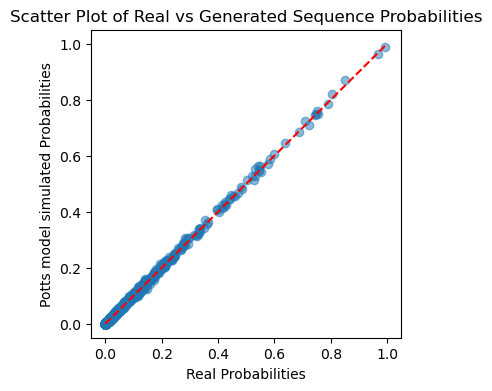

In [19]:
def calc_freq(seqs_int, wts=None):
    if wts is None:
        wts = np.ones(len(seqs_int))
    freqs = np.zeros((nl, nc))
    for idx_seq, seq in enumerate(seqs_int):
        for idx_pos, aa in enumerate(seq):
            freqs[idx_pos, aa] += wts[idx_seq]
    return freqs / wts.sum()
real_p_col = calc_freq(real_seqs_int,wts=wts)
sim_p_col = calc_freq(sim_seqs_int)
# plot these against each other
plt.figure(figsize=(4, 4))
plt.scatter(real_p_col, sim_p_col, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Real Probabilities')
plt.ylabel('Potts model simulated Probabilities')
plt.title('Scatter Plot of Real vs Generated Sequence Probabilities')
plt.show()

The following calulates the joint distribution of every pair of columns--takes a while to run

In [20]:
def calc_pairwise_freq(seqs_int, wts=None):
    if wts is None:
        wts = np.ones(len(seqs_int))
    freqs = np.zeros((nl, nl, nc, nc))
    for idx_seq, seq in enumerate(seqs_int):
        #print(idx_seq)
        for idx_pos1, aa1 in enumerate(seq):
            for idx_pos2, aa2 in enumerate(seq):
                if idx_pos1 != idx_pos2:
                    freqs[idx_pos1, idx_pos2, aa1, aa2] += wts[idx_seq]
    return freqs / wts.sum()
real_p_pair = calc_pairwise_freq(real_seqs_int,wts=wts)
sim_p_pair = calc_pairwise_freq(sim_seqs_int)

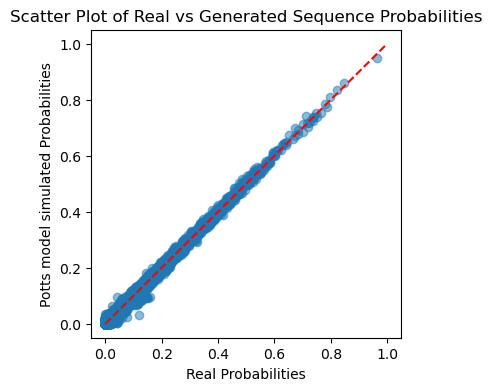

In [21]:
# plot these against each other
plt.figure(figsize=(4, 4))
plt.scatter(real_p_pair[np.triu_indices(nl, k=1)].flatten(), sim_p_pair[np.triu_indices(nl, k=1)].flatten(), alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Real Probabilities')
plt.ylabel('Potts model simulated Probabilities')
plt.title('Scatter Plot of Real vs Generated Sequence Probabilities')
plt.show()

In [22]:
def compute_covariance_matrix(f_i, f_ij):
    """
    Compute the covariance matrix.

    Parameters
    ----------
    f_i : np.array
        Matrix of size nl x nc
        containing marginal probabilities
    f_ij : np.array
        Matrix of size nl x nl x nc x
        nc containing pair probabilities

    Returns
    -------
    np.array
        Matrix of size nl x nl x nc x nc containing
        covariance values. 
        ONLY UPPER TRIANGULAR ENTRIES OF THE nl x nl MATRIX ARE POPULATED--THE REST ARE 0.
    """
    covariance_matrix = np.zeros((
        nl, nl,  nc, nc
    ))
    for i in range(nl):
        for j in range(i + 1, nl):
            for alpha in range(nc):
                for beta in range(nc):
                    covariance_matrix[
                        i, j, alpha, beta
                    ] = f_ij[i, j, alpha, beta] - f_i[i, alpha] * f_i[j, beta]
    return covariance_matrix

real_cov = compute_covariance_matrix(real_p_col, real_p_pair)
sim_cov = compute_covariance_matrix(sim_p_col, sim_p_pair)

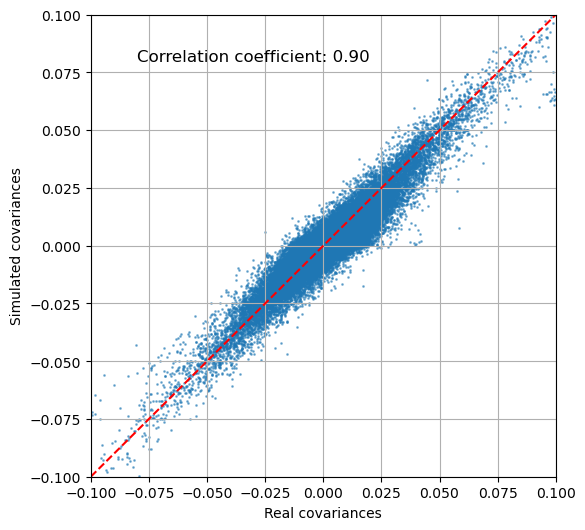

In [23]:
real_cov_flat = real_cov[np.triu_indices(nl, k=1)].flatten()
sim_cov_flat = sim_cov[np.triu_indices(nl, k=1)].flatten()
plt.figure(figsize=(6, 6))
plt.scatter(real_cov_flat, sim_cov_flat, alpha=0.5, s=1)
plt.plot([-.1, .1], [-.1, .1], color='red', linestyle='--')  # Reference line
plt.xlabel('Real covariances')
plt.ylabel('Simulated covariances')
plt.xlim(-.1, .1)
plt.ylim(-.1, .1)
plt.grid()
# add correlation coefficient to plot
cor = np.corrcoef(real_cov_flat, sim_cov_flat)[0, 1]
plt.text(-.08, .08, f"Correlation coefficient: {cor:.2f}", fontsize=12)
plt.show()
